In [1]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.display import display
from sklearn.ensemble import GradientBoostingClassifier
%matplotlib inline

In [2]:
df= pd.read_csv("USDINR.csv")

In [3]:
df['return'] = df['Adj Close'] - df['Adj Close'].shift(1)
return_range = df['return'].max() - df['return'].min()
df['return'] = df['return'] / return_range
df['label'] = df['return'].shift(-1)
df['label'] = df['label'].apply(lambda x: 1 if x>0.0 else 0)
df.dropna(inplace=True)
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,return,label
2603,2019-12-25,71.459999,71.459999,71.187500,71.459999,71.459999,0.0,0.040145,1
2604,2019-12-26,71.335999,71.540001,71.200500,71.540001,71.540001,0.0,0.012883,0
2605,2019-12-27,71.459999,71.561996,71.190002,71.300301,71.300301,0.0,-0.038599,1
2606,2019-12-30,71.410004,71.500000,71.252998,71.313004,71.313004,0.0,0.002046,0
2607,2019-12-31,71.310997,71.537498,71.134804,71.310997,71.310997,0.0,-0.000323,0


In [4]:
n_features = 60 

train_x = np.array([]).reshape([-1,n_features])
train_y = np.array([]).reshape([-1,1])
for index, row in df.iterrows():
    i = df.index.get_loc(index)
    if i<n_features:
        continue
    
    _x = np.array(df[i-n_features+1:i+1]['return']).T.reshape([1, -1])
    _y = df.iloc[i]['label']
    train_x = np.vstack((train_x, _x))
    train_y = np.vstack((train_y, _y))
train_y = train_y.reshape([-1])
print(train_x.shape)
print(train_y.shape)
print('%% of Class0 : %f' % (np.count_nonzero(train_y == 0)/float(len(train_y))))
print('%% of Class1 : %f' % (np.count_nonzero(train_y == 1)/float(len(train_y))))

(2537, 60)
(2537,)
% of Class0 : 0.511628
% of Class1 : 0.488372


In [5]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(random_state=0, learning_rate=0.01, n_estimators=10000)

train_len = int(len(train_x)*0.95)
clf.fit(train_x[:train_len], train_y[:train_len])

accuracy = clf.score(train_x[train_len:], train_y[train_len:])

print('Testing Accuracy: %f' % accuracy)

Testing Accuracy: 0.598425


Enter value of equity:1000


,return,label,pred,won,pnl,equity
121,0.249298,1.0,0.0,False,-249.298,9791.797
122,0.080002,1.0,0.0,False,-80.002,9711.795
123,-0.239700,0.0,0.0,True,239.700,9951.495
124,0.012703,1.0,1.0,True,12.703,9964.198
125,-0.002007,0.0,1.0,False,-2.007,9962.191


,return,label,pred,won,pnl,equity
0,0.409996,1.0,1.0,True,409.996,409.996
1,-0.084999,0.0,1.0,False,-84.999,324.997
2,-0.397400,0.0,1.0,False,-397.400,-72.403
3,0.302399,1.0,0.0,False,-302.399,-374.802
4,-0.119697,0.0,0.0,True,119.697,-255.105


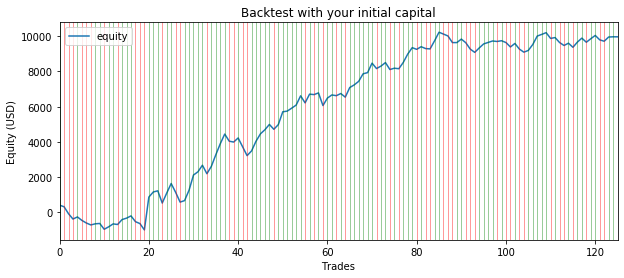

In [6]:

pred = clf.predict(train_x[train_len:])


# Calculate equity..

contracts  = int(input("Enter value of equity:"))
commission = 0.0


df_trade = pd.DataFrame(train_x[train_len:,-1], columns=['return'])
df_trade['label']  = train_y[train_len:]
df_trade['pred']   = pred
df_trade['won']    = df_trade['label'] == df_trade['pred']
df_trade['return'] = df_trade['return'].shift(-1) * return_range
df_trade.drop(df_trade.index[len(df_trade)-1], inplace=True)

def calc_profit(row):
    if row['won']:
        return abs(row['return'])*contracts - commission
    else:
        return -abs(row['return'])*contracts - commission

df_trade['pnl'] = df_trade.apply(lambda row: calc_profit(row), axis=1)
df_trade['equity'] = df_trade['pnl'].cumsum()

display(df_trade.tail())
df_trade.plot(y='equity', figsize=(10,4), title='Backtest with your initial capital')
plt.xlabel('Trades')
plt.ylabel('Equity (USD)')
for r in df_trade.iterrows():
    if r[1]['won']:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='g')
    else:
        plt.axvline(x=r[0], linewidth=0.5, alpha=0.8, color='r')
display(df_trade.head())

Net Profit            : $9962.19
Number Winning Trades : 75
Number Losing Trades  : 50
Percent Profitable    : 60.00%
Avg Win Trade         : $299.374
Avg Los Trade         : $-249.818
Largest Win Trade     : $1863.099
Largest Los Trade     : $-716.293
Profit Factor         : 1.80


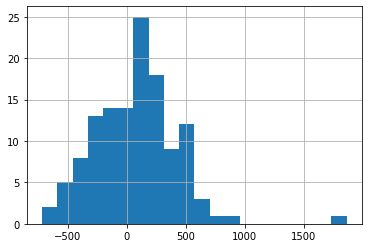

In [7]:
# Calculate summary of trades

n_win_trades = float(df_trade[df_trade['pnl']>0.0]['pnl'].count())
n_los_trades = float(df_trade[df_trade['pnl']<0.0]['pnl'].count())
print("Net Profit            : $%.2f" % df_trade.tail(1)['equity'])
print("Number Winning Trades : %d" % n_win_trades)
print("Number Losing Trades  : %d" % n_los_trades)
print("Percent Profitable    : %.2f%%" % (100*n_win_trades/(n_win_trades + n_los_trades)))
print("Avg Win Trade         : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].mean())
print("Avg Los Trade         : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].mean())
print("Largest Win Trade     : $%.3f" % df_trade[df_trade['pnl']>0.0]['pnl'].max())
print("Largest Los Trade     : $%.3f" % df_trade[df_trade['pnl']<0.0]['pnl'].min())
print("Profit Factor         : %.2f" % abs(df_trade[df_trade['pnl']>0.0]['pnl'].sum()/df_trade[df_trade['pnl']<0.0]['pnl'].sum()))

df_trade['pnl'].hist(bins=20)